In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  1 08:27:46 2022

@author: Seth Sullivan

Simulating matching pennies with the agent. The difference between this and the other 
optimal decision time simulations is that this includes reaction+movement time
so the agent leaves the target at a certain time and 
"""

'\nCreated on Wed Jun  1 08:27:46 2022\n\n@author: Seth Sullivan\n\nSimulating matching pennies with the agent. The difference between this and the other \noptimal decision time simulations is that this includes reaction+movement time\nso the agent leaves the target at a certain time and \n'

In [1]:
import numpy as np 
import scipy 
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm
import os
import random
from tqdm import tqdm
import numba as nb
from numba import njit
from numba import jit
import matplotlib.animation as animation
from textwrap import wrap
import data_visualization as dv

ModuleNotFoundError: No module named 'data_visualization'

In [3]:
wheel = dv.ColorWheel()
PATH = 'D:\Subject_Data\Seth_MatchPennies_Agent_Pilot_v2'

In [4]:
def update_params(label_color):
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              }
    plt.rcParams.update(params)   

In [5]:
# No gambles
num_trials = 10000
num_blocks = 6
player_reach_time = np.zeros((num_trials, num_blocks))
agent_reach_time = np.zeros((num_trials, num_blocks))
agent_leave_time = np.zeros((num_trials, num_blocks))
reaction_movement_time = np.zeros((num_trials, num_blocks))
wins = np.zeros(num_blocks)
indecisions = np.zeros(num_blocks)
agent_reach_means = [1100,1100,1300,1300,1500,1500]
agent_reach_sds = [100,200]*3
for j in range(num_blocks):
    agent_reach_time[:,j] = norm.rvs(agent_reach_means[j],agent_reach_sds[j],num_trials)
    agent_leave_time[:,j] = agent_reach_time[:,j] - 300
    reaction_movement_time[:,j] = norm.rvs(250,30,num_trials)
    player_reach_time[:,j] = agent_leave_time[:,j] + reaction_movement_time[:,j]
    wins[j] = np.count_nonzero(player_reach_time[:,j]<1500)
    indecisions[j] = np.count_nonzero(player_reach_time[:,j]>=1500)
perc_wins = wins/num_trials*100
perc_indecisions = indecisions/num_trials*100

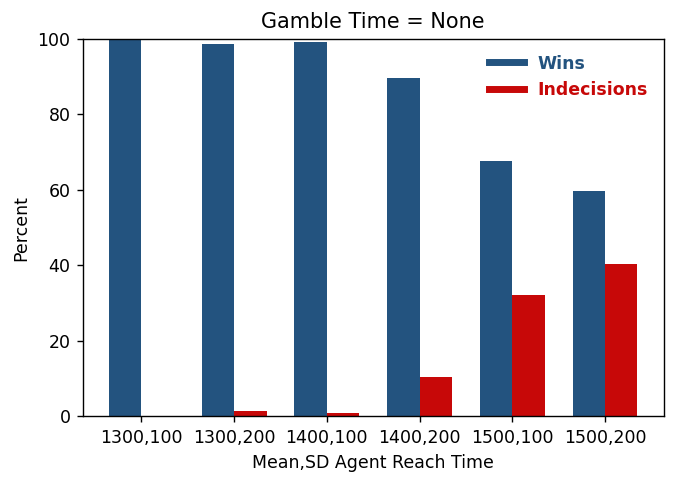

In [6]:
# Plot
plt.figure(dpi =125)
ax = plt.subplot()
xlocs = np.arange(num_blocks)
xlabs = ['1300,100', '1300,200','1400,100', '1400,200','1500,100', '1500,200']
width = 0.35
ax.bar(xlocs - width/2 ,perc_wins, width = width, label = 'Wins', color = wheel.dark_blue)
ax.bar(xlocs + width/2, perc_indecisions, width = width, label = 'Indecisions', color = wheel.dark_red)
ax.set_xticks(xlocs)
ax.set_xticklabels(xlabs)
ax.set_xlabel('Mean,SD Agent Reach Time')
ax.set_ylabel('Percent')
ax.set_ylim(0,100)
labels = ["Wins", "Indecisions"]
colors = [wheel.dark_blue, wheel.dark_red]
dv.Custom_Legend(ax, labels, colors, fontsize = 10)
ax.set_title('Gamble Time = None')
plt.show()

In [7]:
#%% Gamble time = 1000
def run_simulation(num_trials, num_blocks, gamble_time_means, gamble_time_sd,agent_reach_means, agent_reach_sds, 
                   player_reaction_mean, player_reaction_sd, player_movement_mean, player_movement_sd):
    player_reach_time = np.zeros((len(gamble_time_means),num_blocks,num_trials))
    player_decision_time = np.zeros((len(gamble_time_means),num_blocks,num_trials))
    agent_reach_time = np.zeros((len(gamble_time_means),num_blocks,num_trials))
    agent_leave_time = np.zeros((len(gamble_time_means),num_blocks,num_trials))
    reaction_time = np.zeros((len(gamble_time_means),num_blocks,num_trials))
    movement_time = np.zeros((len(gamble_time_means),num_blocks,num_trials))
    gamble_time = np.zeros((len(gamble_time_means),num_blocks,num_trials))
    reaction_wins = np.zeros((len(gamble_time_means),num_blocks))
    indecisions = np.zeros((len(gamble_time_means),num_blocks))
    gamble_wins = np.zeros((len(gamble_time_means),num_blocks))
    gamble_losses = np.zeros((len(gamble_time_means),num_blocks))
    
    for i in range(len(gamble_time_means)):
        for j in range(num_blocks):
            gamble_time_mean, gamble_time_sd = gamble_time_means[i], gamble_time_sd # This should be the timing ability sd from data
            agent_reach_time[i,j,:] = norm.rvs(agent_reach_means[j],agent_reach_sds[j],num_trials)
            agent_leave_time[i,j,:] = agent_reach_time[i,j,:] - 300
            reaction_time[i,j,:] = norm.rvs(player_reaction_mean,player_reaction_sd,num_trials)
            movement_time[i,j,:] = norm.rvs(player_movement_mean,player_movement_sd,num_trials)
            player_reach_time[i,j,:] = agent_leave_time[i,j,:] + reaction_time[i,j,:] + movement_time[i,j,:] # We assume people react to everything, then the gamble in the next loop changes this
            player_decision_time[i,j,:] = agent_leave_time[i,j,:] + reaction_time[i,j,:]
            gamble_time[i,j,:] = norm.rvs(gamble_time_mean, gamble_time_sd, num_trials)
            
        for j in range(num_blocks):
            for k in range(num_trials):
                # Player decides to gamble
                if agent_leave_time[i,j,k]>gamble_time[i,j,k]:
                    player_reach_time[i,j,k] = gamble_time[i,j,k] + movement_time[i,j,k] # Gamble time is the time we decide, so the reach time is time we decide plus only movement time, because there's no reaction 
                    player_decision_time[i,j,k] = gamble_time[i,j,k] + reaction_time[i,j,k]
                    if player_reach_time[i,j,k]>1500:
                        indecisions[i,j]+=1
                    elif agent_reach_time[i,j,k]>1500:
                        gamble_wins[i,j]+=1
                    else: # Both under 1500
                        r = random.uniform(0,1)
                        if r>0.5:
                            gamble_wins[i,j]+=1
                        else:
                            gamble_losses[i,j]+=1
                # Player decides to react, did they reach the target before 1500?
                elif player_reach_time[i,j,k]>1500:
                    indecisions[i,j]+= 1
                elif player_decision_time[i,j,k]-agent_leave_time[i,j,k] >= reaction_time[i,j,k]:
                    reaction_wins[i,j]+=1
                elif player_decision_time[i,j,k]-agent_leave_time[i,j,k]<reaction_time[i,j,k]:
                    r = random.uniform(0,1)
                    if r>0.5:
                        gamble_wins[i,j]+=1
                    else:
                        gamble_losses[i,j]+=1
                else:
                    print(agent_leave_time[i,j,k], player_decision_time[i,j,k], player_reach_time[i,j,k])
                    
                    
    perc_reaction_wins = (reaction_wins/num_trials)*100
    perc_gamble_wins = (gamble_wins/num_trials)*100
    perc_gamble_losses = (gamble_losses/num_trials)*100
    perc_indecisions = (indecisions/num_trials)*100
    perc_total_wins = perc_reaction_wins + perc_gamble_wins
    return perc_reaction_wins, perc_gamble_wins, perc_gamble_losses, perc_indecisions, perc_total_wins


In [8]:
gamble_time_means = np.arange(1000,1500,50)
gamble_time_sd = 50
agent_reach_means = [1100,1100,1300,1300,1500,1500]
#agent_reach_means = [1200,1200,1400,1400,1600,1600]
agent_reach_sds = [25,50]*3
#agent_reach_sds = np.linspace(50,400,6, dtype = int)
player_reaction_mean, player_reaction_sd = 250, 100
player_movement_mean, player_movement_sd = 150, 40
num_trials = 10000


perc_reaction_wins, perc_gamble_wins, perc_gamble_losses, perc_indecisions, perc_total_wins = run_simulation(num_trials,6,gamble_time_means,gamble_time_sd, 
                                                                                                             agent_reach_means, agent_reach_sds, 
                                                                                                             player_reaction_mean, player_reaction_sd,
                                                                                                             player_movement_mean, player_movement_sd)

0


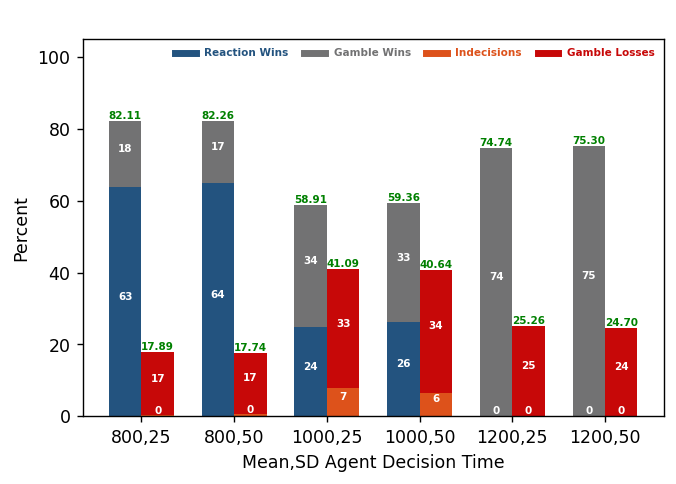

1


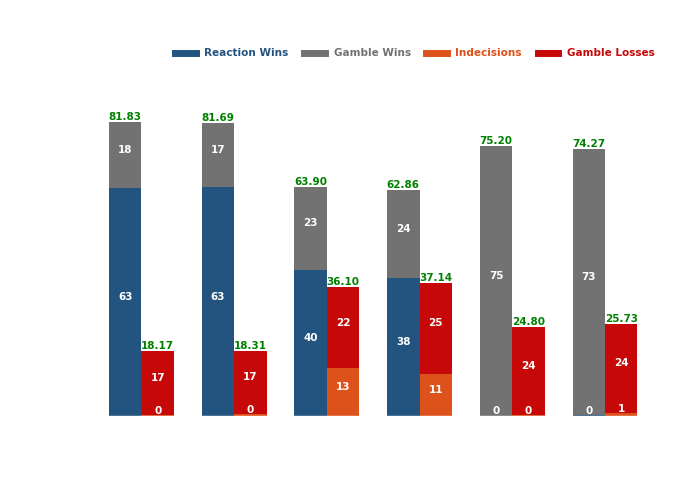

2


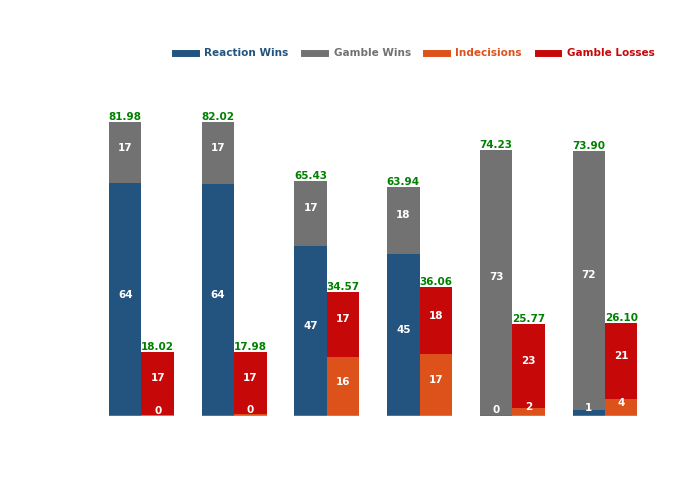

3


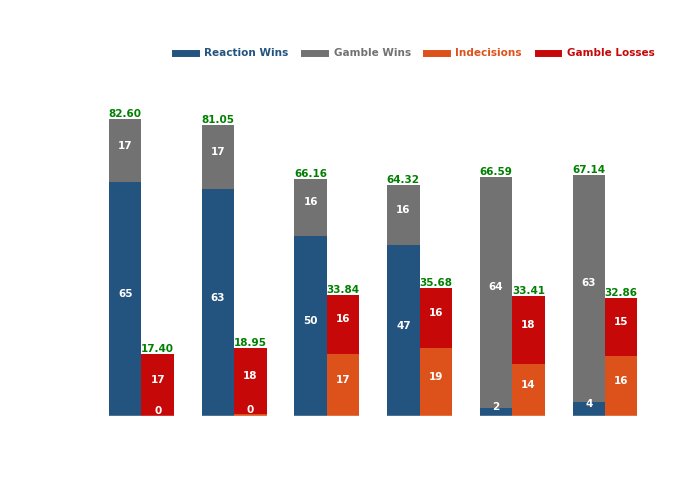

4


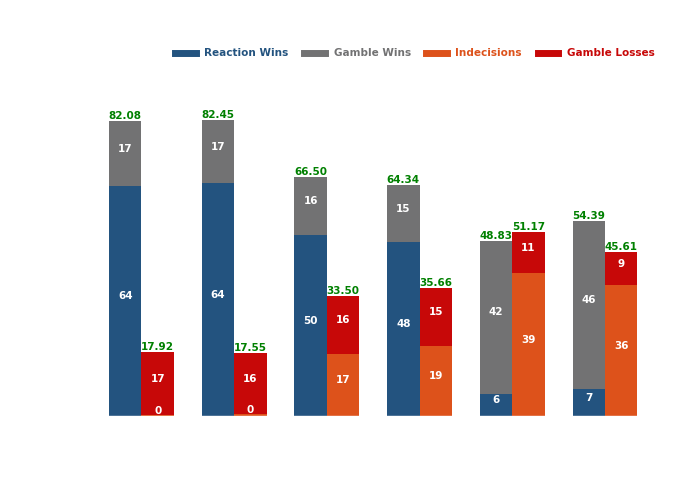

5


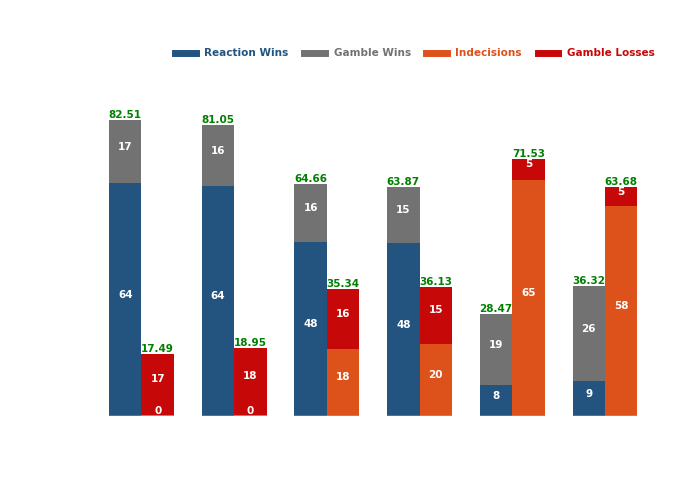

6


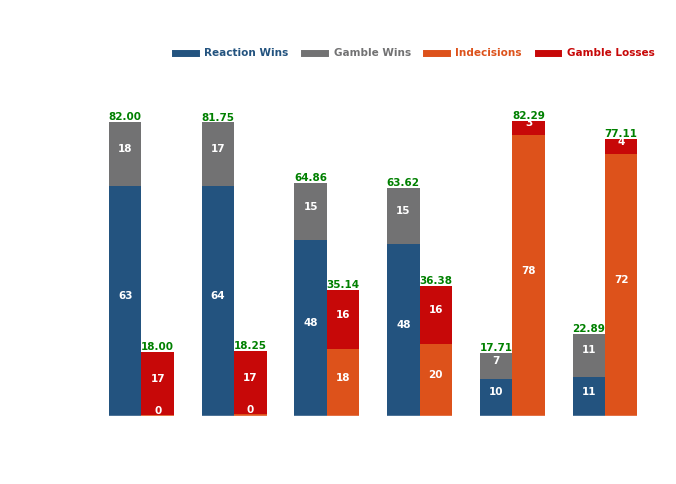

7


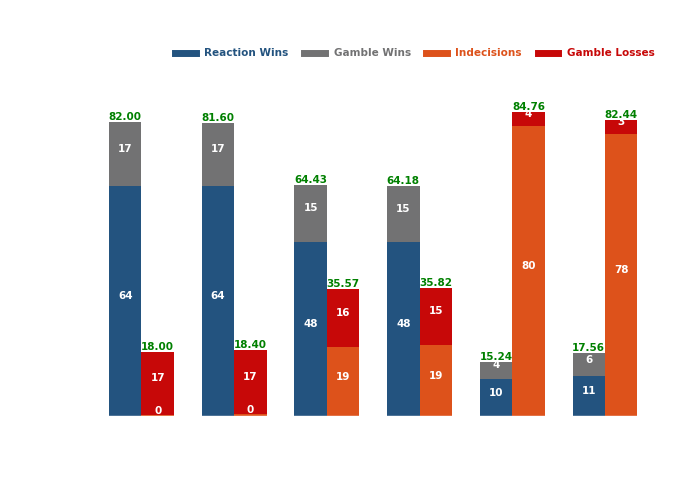

8


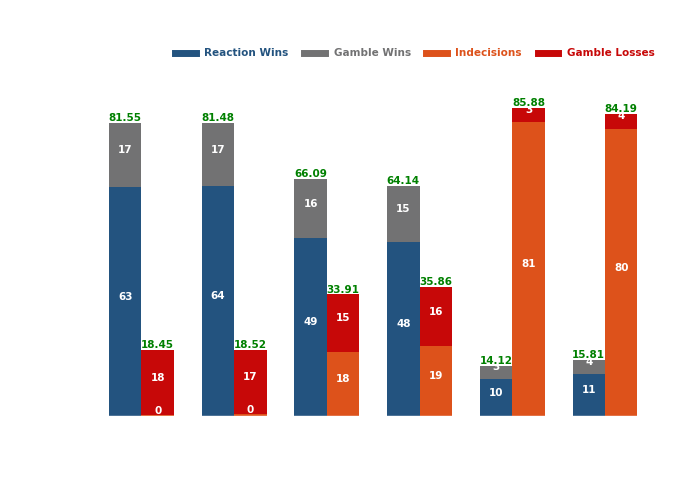

9


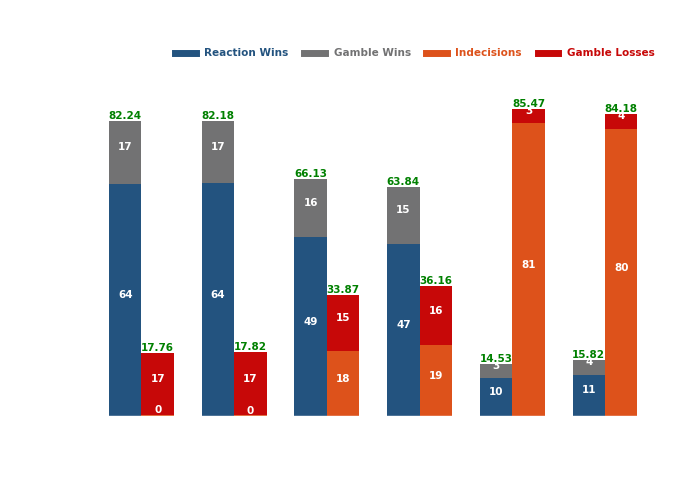

In [9]:
#%% Plot wins and indecisions for gambles and reactions
agent_decision_means = np.array(agent_reach_means)-300
for x in range(len(gamble_time_means)):
    print(x)
    plt.figure(dpi = 125)
    ax = plt.subplot()
    update_params('w')
    xlocs = np.arange(num_blocks)
    xlabs = []
    for mean,sd in zip(agent_decision_means, agent_reach_sds):
        xlabs.append(f'{mean},{sd}')
    width = 0.35
    rect1 = ax.bar(xlocs - width/2, perc_reaction_wins[x,:], width = width, label = 'Reaction Wins', color = wheel.dark_blue)
    rect2 = ax.bar(xlocs - width/2, perc_gamble_wins[x,:], width = width, label = 'Gamble Wins', color = wheel.dark_grey, bottom = perc_reaction_wins[x,:])
    rect3 = ax.bar(xlocs + width/2, perc_indecisions[x,:], width = width, label = 'Indecisions', color = wheel.autumn)
    rect4 = ax.bar(xlocs + width/2, perc_gamble_losses[x,:], width = width, label = 'Gamble Losses', color = wheel.dark_red, bottom = perc_indecisions[x,:])

    ax.set_xticks(xlocs)
    ax.set_xticklabels(xlabs)
    ax.set_xlabel('Mean,SD Agent Decision Time')
    ax.set_ylabel('Percent')
    ax.set_ylim(0,105)

    labels = ["Reaction Wins","Gamble Wins", "Indecisions", "Gamble Losses"]
    colors = [wheel.dark_blue,wheel.dark_grey, wheel.autumn, wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors, fontsize = 6, ncol=4, columnspacing=1.5)
    ax.set_title(f'Gamble Time Mean = {gamble_time_means[x]}')
    for r1, r2, r3, r4 in zip(rect1, rect2, rect3, rect4):
        h1 = r1.get_height()
        h2 = r2.get_height()
        h3 = r3.get_height()
        h4 = r4.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r3.get_x() + r3.get_width() / 2., h3 / 2., "%d" % h3, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r4.get_x() + r4.get_width() / 2., h3+h4 / 2., "%d" % h4, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2, f'{h1+h2:0.2f}', ha="center", va="bottom", color="green", fontsize=6, fontweight="bold")
        plt.text(r4.get_x() + r2.get_width() / 2., h3 + h4, f'{h3+h4:0.2f}', ha="center", va="bottom", color="green", fontsize=6, fontweight="bold")
    plt.savefig(PATH+'\\Modeling_Figures\\'+f'agent_reaction_sim_gamble_{gamble_time_means[x]}', dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

In [10]:
player_decision_time

NameError: name 'player_decision_time' is not defined

In [ ]:
player_reach_time_mean = np.nanmean(player_reach_time, axis = 2)
optimal_index = np.argmax(perc_total_wins,axis=0)
for i in optimal_index:
    optimal_player_reach_time_mean = player_reach_time_mean[i,j]
fig,ax = plt.subplots(dpi = 125, figsize = (18,6))
xlocs = np.arange(num_blocks)
xlabs = ['1000,100', '1000,200','1100,100', '1100,200','1200,100', '1200,200']
width = 0.1
color = plt.cm.viridis(np.linspace(0, 1, 10))
rect1 = ax.bar(xlocs - width*2, player_reach_time_mean[0,:], width = width, label = f'Gamble = {gamble_time[0]}', color = color[0])
rect2 = ax.bar(xlocs - width*1, player_reach_time_mean[1,:], width = width, label = f'Gamble = {gamble_time[1]}', color = color[1])
rect3 = ax.bar(xlocs, player_reach_time_mean[2,:], width = width, label = f'Gamble = {gamble_time[2]}', color = color[2])
rect4 = ax.bar(xlocs + width*1, player_reach_time_mean[3,:], width = width, label = f'Gamble = {gamble_time[3]}', color = color[3])
rect5 = ax.bar(xlocs + width*2, player_reach_time_mean[4,:], width = width, label = f'Gamble = {gamble_time[4]}', color = color[4])
#rect6 = ax.bar(xlocs + width, perc_gamble_losses[3,:], width = width, label = f'Gamble = {gamble_time[3]}', color = wheel.dark_red)

ax.set_xticks(xlocs)
ax.set_xticklabels(xlabs)
ax.set_xlabel('Mean,SD Agent Decision Time')
ax.set_ylabel('Time(ms)')
ax.set_ylim(0,2000)
ax.set_title('Optimal Mean Decision Time for each Gamble Time')
# labels = [f'Gamble = {gamble_time[0]}',f'Gamble = {gamble_time[1]}',f'Gamble = {gamble_time[2]}', f'Gamble = {gamble_time[3]}',f'Gamble = {gamble_time[4]}']
# colors = [color[0],color[1],color[2],color[3],color[4]]
# dv.Custom_Legend(ax, labels, colors, fontsize = 10)

# for r1, r2, r3, r4 in zip(rect1, rect2, rect3, rect4):
#     h1 = r1.get_height()
#     h2 = r2.get_height()
#     h3 = r3.get_height()
#     h4 = r4.get_height()
#     plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
#     plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
#     plt.text(r3.get_x() + r3.get_width() / 2., h3 / 2., "%d" % h3, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
#     plt.text(r4.get_x() + r4.get_width() / 2., h4 / 2., "%d" % h4, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
#     plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2, f'{h1+h2:0.2f}', ha="center", va="bottom", color="green", fontsize=6, fontweight="bold")
#     plt.text(r4.get_x() + r2.get_width() / 2., h3 + h4, f'{h3+h4:0.2f}', ha="center", va="bottom", color="green", fontsize=6, fontweight="bold")
plt.show()

In [ ]:
# Find optimal gamble time and plot 
optimal_index = np.argmax(perc_total_wins, axis = 0 )
optimal_gamble_time = np.zeros((num_blocks))
c=-1
for i in optimal_index:
    c+=1
    optimal_gamble_time[c] = gamble_time_means[i]

In [ ]:
optimal_gamble_time

array([1400., 1100., 1100., 1100., 1050., 1050.])

array([1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450])